# Training a DPNets-MLP on the logistic map data.

The main training problem is that the feature map gets stuck in a low-rank subspace and is unable to exit from it:
Strategies:
1. Studying & changing initializations
2. Changing the model
3. Gradient magnitudes
4. **Covariance of the intermediate activations**

I will implement the training loop in plain `torch` to study the problem.

In [113]:
import torch
from torch.utils.data import DataLoader
from kooplearn.nn.data import TrajToContextsDataset
from kooplearn.nn.functional import VAMP_score, relaxed_projection_score, log_fro_metric_deformation_loss

#Plotting
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['nature', 'retro'])
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9

#### Load Configs

In [112]:
import ml_confs as mlcfg
configs = mlcfg.from_file('dev_cfg.yaml', register_jax_pytree=False)

#### Unit-testing and convenience functions

In [104]:
def tensor_info(batch: torch.Tensor):
    print("------------------------------------")
    print(f"Shape: {tuple(batch.shape)}")
    print(f"Data limits : [{batch.min().item():.2e}, {batch.max().item():.2e}]")
    print(f"Variance: {batch.flatten().var().item():.2e}")

def plot_distribution_dict(distribution_dict):
    fig, ax = plt.subplots(1, 1, figsize=(9, 2.5))
    for key, value in distribution_dict.items():
        hy, hx = torch.histogram(value, density=True)
        ax.plot(hx[1:], hy, label=key)
    ax.legend(frameon=False)
    ax.set_xmargin(0)
    return fig

#### Data preparation

In [82]:
from kooplearn.datasets import LogisticMap
logistic = LogisticMap(N = configs.N)

sample_traj = logistic.sample(0.5, configs.num_train+configs.num_val+configs.num_test)
dataset = {
    'train': sample_traj[:configs.num_train],
    'validation': sample_traj[configs.num_train:configs.num_train+configs.num_val],
    'test': sample_traj[configs.num_train+configs.num_val:]
}

#Preparing the data
train_data = torch.from_numpy(dataset['train']).float()
val_data = torch.from_numpy(dataset['validation']).float()

train_ds = TrajToContextsDataset(train_data)
val_ds = TrajToContextsDataset(val_data)

train_dl = DataLoader(train_ds, batch_size=configs.batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=False)

#Test shape of data
for batch in train_dl:
    tensor_info(batch)
    break

Shape: (2048, 2, 1)
Data limits : [1.70e-04, 1.00e+00]
Variance: 0.10


#### Defining the model

In [91]:
class SinusoidalEmbedding(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        #Assuming x is in [0, 1]
        x = 2*torch.pi*x
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)

class SimpleMLP(torch.nn.Module):
    def __init__(self, feature_dim: int, layer_dims: list[int], activation = torch.nn.Tanh):
        super().__init__()
        _layers_sizes = [2] + layer_dims + [feature_dim] #The 2 is for the sinusoidal embedding
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(_layers_sizes[i], _layers_sizes[i+1], bias=False) for i in range(len(_layers_sizes) - 1)])
        self.activation = activation()
        self.sin_embedding = SinusoidalEmbedding()
    
    def forward(self, x):
        #Sinusoidal embedding
        x = self.sin_embedding(x)
        for layer in self.linear_layers[:-1]:
            x = self.activation(layer(x))
        return self.linear_layers[-1](x)

def kaiming_init(model):
    for p in model.parameters():
        out_shape, in_shape = p.shape
        if in_shape == 2:
            #Initial layer
            torch.nn.init.uniform_(p, -1, 1)
        else:
            torch.nn.init.kaiming_uniform_(p, a= 1, nonlinearity=model.activation.__class__.__name__.lower())

##### Activation shapes

SinusoidalEmbedding
------------------------------------
Shape: (2048, 2)
Data limits : [-1.00e+00, 1.00e+00]
Variance: 4.95e-01

Layer 0 - Activations
------------------------------------
Shape: (2048, 512)
Data limits : [-8.77e-01, 8.77e-01]
Variance: 2.16e-01

Layer 1 - Activations
------------------------------------
Shape: (2048, 512)
Data limits : [-9.90e-01, 9.90e-01]
Variance: 3.19e-01

Layer 2 - Activations
------------------------------------
Shape: (2048, 4)
Data limits : [-1.42e+00, 1.42e+00]
Variance: 4.60e-01


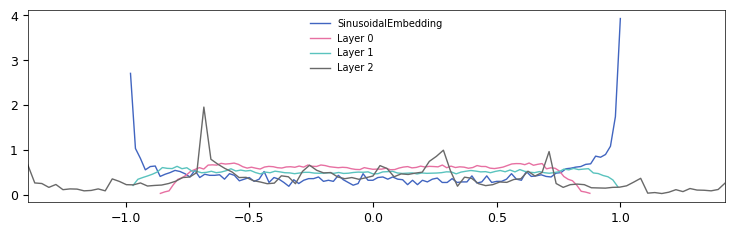

In [105]:
torch.manual_seed(configs.rng_seed)
mlp = SimpleMLP(configs.feature_dim, configs.layer_dims)
kaiming_init(mlp)
activations = {}
#Replicating the forward pass on a small batch
for batch in train_dl:
    x = batch[:, 0, :]
    print("SinusoidalEmbedding")
    x = mlp.sin_embedding(x)
    activations['SinusoidalEmbedding'] = x.detach().flatten()
    tensor_info(x)
    for i, layer in enumerate(mlp.linear_layers[:-1]):
        print(f"\nLayer {i} - Activations")
        x = mlp.activation(layer(x))
        activations[f"Layer {i}"] = x.detach().flatten()
        tensor_info(x)
    print(f"\nLayer {len(mlp.linear_layers)-1} - Activations")
    x = mlp.linear_layers[-1](x)
    activations[f"Layer {len(mlp.linear_layers)-1}"] = x.detach().flatten()
    tensor_info(x) 
    break  
plot_distribution_dict(activations);   

#### Setting up the training loop

In [127]:
#Fast-changing configs
lr = 1e-4
use_relaxed_loss = False
metric_deformation_loss_coefficient = 0.0

#Opt
torch.manual_seed(configs.rng_seed)
optimizer = torch.optim.Adam(mlp.parameters(), lr=lr)
#Model init
torch.manual_seed(configs.rng_seed)
mlp = SimpleMLP(configs.feature_dim, configs.layer_dims)
kaiming_init(mlp)

torch.manual_seed(configs.rng_seed)
mlp_lagged = SimpleMLP(configs.feature_dim, configs.layer_dims)
kaiming_init(mlp_lagged)

#The two modules should have the same initial weights
for p1, p2 in zip(mlp.parameters(), mlp_lagged.parameters()):
    assert torch.allclose(p1, p2)
#Print the number of parameters
print(f"{int(sum(p.numel() for p in mlp.parameters())/1000.0)}k parameters in each MLP")

265k parameters in each MLP


------------------------------------
Shape: (512, 2)
Data limits : [-2.96e+02, 2.41e+02]
Variance: 3.69e+03
------------------------------------
Shape: (512, 512)
Data limits : [-2.27e+02, 2.26e+02]
Variance: 7.75e+02
------------------------------------
Shape: (4, 512)
Data limits : [-1.67e+03, 9.14e+02]
Variance: 4.30e+04


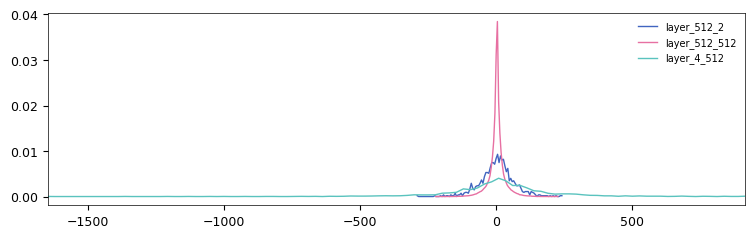

In [130]:
score = []
md = []
grads = {}
global_step = 0
break_point = 1000
#Training Loop
for epoch in range(configs.num_epochs):
    print(f"Epoch {epoch + 1}", end='\r')
    for batch in train_dl:
        global_step += 1
        X, Y = batch[:, 0, ...], batch[:, 1, ...]
        #Encoding
        encoded_X, encoded_Y = mlp.forward(X), mlp_lagged.forward(Y)
        _norm = torch.rsqrt(torch.tensor(encoded_X.shape[0]))
        encoded_X *= _norm
        encoded_Y *= _norm
        #Compute the covariances
        cov_X = torch.mm(encoded_X.T, encoded_X)
        cov_Y = torch.mm(encoded_Y.T, encoded_Y)
        cov_XY = torch.mm(encoded_X.T, encoded_Y)
        #Compute the losses
        if use_relaxed_loss:
            loss = -1*relaxed_projection_score(cov_X, cov_Y, cov_XY)
            score.append(-1.0*loss.item())
        else:
            loss = -1*VAMP_score(cov_X, cov_Y, cov_XY, schatten_norm=2)
            score.append(-1.0*loss.item())

        if metric_deformation_loss_coefficient > 0.0:
            metric_deformation_loss = 0.5*(log_fro_metric_deformation_loss(cov_X) + log_fro_metric_deformation_loss(cov_Y))
            metric_deformation_loss = metric_deformation_loss*metric_deformation_loss_coefficient
            md.append(metric_deformation_loss.item())
            loss += metric_deformation_loss
        
        #Optimization step
        optimizer.zero_grad()
        loss.backward()
        if global_step == break_point:    
            #Inspect gradients
            for p in mlp.parameters():
                tensor_info(p.grad)
                grads[f'layer_{p.shape[0]}_{p.shape[1]}'] = p.grad.flatten().detach()
            break
        optimizer.step()
    if global_step == break_point:
        break
plot_distribution_dict(grads);